## Lab 3: Where is the nearest cafe?

**Objectives:**
   * We will explore OpenStreetMap (OSM) data using <code>osmnx</code>.
   * Learn about OSM data stuctures
   * Compute walking distances using just a few lines of code
   * Visualize our data using `folium`

We will be relying heavily on <code>osmnx</code> which is a package that enables automatic download of geospatial data from OSM and allows us to model, project, visualize, and analyze real-world street networks. More information about this package can be found [here](https://osmnx.readthedocs.io/en/stable/) and the [GitHub repo](https://github.com/gboeing/osmnx/tree/6f9236f20a81416bf34186a811a8ebb76afa0dc8)

We will start with a simple example that calculates the Euclidean distance between Condon Hall and some cafes in Eugene. After that, we will use the <code>networkx</code> package to calculate actual walking distances from Condon Hall to the cafes.

### Create a new environment and launch the notebook

As always, make a new environment that contains all the packages for this lab. Navigate to the `labs/lab3` folder (either from the terminal for Linux and Mac users or from the **CMD.exe Prompt** launched from **Anaconda Navigator** for Windows users) and run:

`conda env create -f environment.yml`

Activate this environment by running:

`conda activate lab3`

Now launch the notebook by running:

`jupyter notebook 03_walking_distances.ipynb`

In [1]:
# Import modules
!pip install osmnx==1.2.0
import osmnx as ox

import numpy as np
import geopandas as gpd

from shapely.geometry.polygon import Polygon
from shapely.geometry.multipolygon import MultiPolygon
from shapely.geometry import LineString, MultiLineString
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.5 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of geopandas to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 543.2/543.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 39.1 MB/s eta 0:00:00
  Attempting uninstall: Shapely
    Found existing installation: shapely 2.0.6
    Uninstalling shapely-2.0.6:
      Successfully uninstalled shapely-2.0.6
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalle

### Retrieve OSM data

First we will retrieve all features labelled (or tagged) as buildings in Eugene.

In [2]:
# Specify type of data
tags = {'building': True}

# Download building geometries from OSM
gdf = ox.geometries_from_place('Eugene, Oregon, USA', tags)

It did not take long to download all this data even though this GeoDataFrame is massive (don't worry about the error message!). We can find the number of buildings in Eugene by printing the shape of the GeoDataFrame.

In [3]:
print(gdf.shape)

(59944, 332)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We can find out what attributes are contained in this GeoDataFrame by printing the column headers as a list.

In [4]:
print(gdf.columns.tolist())

['addr:state', 'building', 'ele', 'gnis:feature_id', 'name', 'operator', 'geometry', 'access', 'wheelchair', 'source', 'amenity', 'description', 'opening_hours', 'information', 'tourism', 'level', 'addr:housenumber', 'addr:postcode', 'addr:street', 'bus', 'network', 'public_transport', 'fee', 'leisure', 'sport', 'material', 'addr:city', 'check_date', 'emergency', 'man_made', 'website', 'takeaway', 'toilets', 'parking', 'brand', 'brand:wikidata', 'drive_through', 'indoor', 'operator:wikidata', 'layer', 'ref', 'height', 'nodes', 'addr:place', 'building:levels', 'contact:sms', 'internet_access', 'phone', 'shop', 'url', 'wikidata', 'wikipedia', 'atm', 'contact:website', 'fast_food', 'fuel:propane', 'name:ja', 'compressed_air', 'addr:unit', 'denomination', 'religion', 'cuisine', 'internet_access:fee', 'smoking', 'government', 'office', 'email', 'capacity', 'location', 'delivery', 'payment:cash', 'payment:credit_cards', 'payment:debit_cards', 'start_date', 'internet_access:ssid', 'outdoor_se

Since OSM is entirely based on volunteered geographic information, there are a lot of attributes, most of which are not complete. We can find the number of non-NaNs in each column by typing:

In [6]:
# Count number of non-NaNs in each
warnings.filterwarnings("ignore", category=DeprecationWarning)
gdf.count()

,0
addr:state,43384
building,59944
ele,18
gnis:feature_id,19
name,1321
...,...
fuel:gasoline_93,1
diet:non-vegetarian,1
ways,88
type,88


For the purposes of this assignment, we are only interested in buildings that are tagged as **cafes**. Cafes are usually tagged as an **amenity** in OSM so we can filter them using a string comparison.

In [5]:
# Filter cafes

warnings.filterwarnings("ignore", category=DeprecationWarning)
cafes = gdf[gdf['amenity'] == 'cafe'].reset_index()
cafes

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

,element_type,osmid,addr:state,building,ele,gnis:feature_id,name,operator,geometry,access,...,delivery:partner,service:vehicle:rv_repair,service:vehicle:trailers,service:vehicle:truck_repair,landuse,fuel:gasoline_93,diet:non-vegetarian,ways,type,contact:tiktok
0,way,123493968,OR,yes,NaN,NaN,The Human Bean,NaN,"POLYGON ((-123.14675 44.04824, -123.14675 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,way,221500325,NaN,retail,NaN,NaN,Brail's Espresso,NaN,"POLYGON ((-123.09262 44.04138, -123.09254 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,way,244977193,OR,yes,NaN,NaN,TopCity Frozen Yogurt Cafe,NaN,"POLYGON ((-123.11633 44.04085, -123.11633 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,way,244983219,OR,yes,NaN,NaN,Starbucks,NaN,"POLYGON ((-123.06465 44.04601, -123.06451 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,way,266746620,OR,commercial,NaN,NaN,Starbucks,NaN,"POLYGON ((-123.09120 44.02803, -123.09103 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,way,277456563,NaN,yes,NaN,NaN,Espresso Roma,NaN,"POLYGON ((-123.07985 44.04560, -123.07964 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,way,283863396,OR,yes,NaN,NaN,Dutch Bros. Coffee,NaN,"POLYGON ((-123.06118 44.04503, -123.06111 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,way,414520035,OR,yes,NaN,NaN,Romano's,NaN,"POLYGON ((-123.18510 44.08472, -123.18515 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,way,420982688,NaN,yes,NaN,NaN,Voodoo Doughnut,NaN,"POLYGON ((-123.09231 44.04983, -123.09242 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,way,421453808,OR,yes,NaN,NaN,Dutch Bros. Coffee,NaN,"POLYGON ((-123.08790 44.04789, -123.08790 44.0...",NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We find that there are 33 cafes in Eugene. This could well be an underestimate since there could be cafes that were not tagged as amenities when mapped. But let's keep moving forward.

### Computing Euclidean distances to cafes from Condon Hall

We now want to compute the distance to ten nearest cafes. First we will have to reproject our data to UTM Zone 10N which is a projection system that contains Oregon (https://epsg.io/32610)

In [7]:
# Reproject to UTM Zone 10N
warnings.filterwarnings("ignore", category=DeprecationWarning)
gdf = gdf.to_crs('EPSG:32610')
cafes = cafes.to_crs('EPSG:32610')

Find the coordinates of Condon Hall by searching for **Condon Hall** in the original GeoDataFrame.

In [8]:
# Get coordinates of Condon Hall
warnings.filterwarnings("ignore", category=DeprecationWarning)
condon_hall = gdf[gdf['name'] == 'Condon Hall'].reset_index()

Compute building centroids so we can compute point-to-point distances.

In [9]:
# Get cafe and Condon Hall centroids
warnings.filterwarnings("ignore", category=DeprecationWarning)
cafes['centroid'] = cafes['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

condon_hall['centroid'] = condon_hall['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

Now we can compute the Euclidean distances between Condon Hall and the cafes

In [10]:
# Compute distances
warnings.filterwarnings("ignore", category=DeprecationWarning)
condon_hall_x = condon_hall['centroid'].x.values[0]
condon_hall_y = condon_hall['centroid'].y.values[0]
distances = np.sqrt(((condon_hall_x - cafes['centroid'].x.values)**2)
                     + ((condon_hall_y - cafes['centroid'].y.values)**2))

# Add to GeoDataFrame
cafes['euclidean_distance'] = distances

...and print a list of the ten closest cafes to Condon Hall

In [11]:

warnings.filterwarnings("ignore", category=DeprecationWarning)
print(cafes.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance']])

                            name  euclidean_distance
5                  Espresso Roma          135.288663
9             Dutch Bros. Coffee          830.864189
3                      Starbucks         1094.038306
10                        Palace         1115.624529
1               Brail's Espresso         1225.005794
8                Voodoo Doughnut         1240.797103
15                 Amazon Coffee         1296.504962
6             Dutch Bros. Coffee         1369.368652
31            Dutch Bros. Coffee         1519.720322
25  The Quick Fix Coffee Company         1844.810972


Now for a bit of magic, let's visualize our data using `folium`

In [12]:
# Make a new DataFrame containing only the three most relevant columns
warnings.filterwarnings("ignore", category=DeprecationWarning)
nearest_cafes = cafes.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance', 'centroid']]

# Set column geometry
nearest_cafes = nearest_cafes.set_geometry('centroid')

# Convert back to WGS84
nearest_cafes = nearest_cafes.to_crs('EPSG:4326')

# Import package
import folium

# Define center of map (i.e. Condon Hall) and initial zoom level
lat_lon = [44.0451, -123.0781]
m = folium.Map(location=lat_lon, zoom_start=15)

for i in range(0, nearest_cafes.shape[0]):
    my_string = 'name: {}, distance: {}'.format(nearest_cafes.iloc[i]['name'], nearest_cafes.iloc[i]['euclidean_distance'])
    folium.Marker([nearest_cafes.iloc[i]['centroid'].y, nearest_cafes.iloc[i]['centroid'].x],
                 popup=my_string).add_to(m)

# Display map
m

Click on the markers above and a pop-up should appear showing the name of the cafe and Euclidean distance (in meters) from Condon Hall.

## Question 1 (20 points):
Write a script that:

* Computes the Euclidean distance to another **amenity** of your choosing (HINT: use `gdf['amenity'].unique()` to list the different amenities). Feel free to download OSM buildings from another place and choose a different home' location.


* Makes an interactive map showing where your ten nearest amenities are using `folium`.

### Computing network distances

Euclidean distances often underestimate the distance between two objects, especially when there are obstacles between the two. So we will now compute some more realistic distances to cafes around Condon Hall. First we will need to import the [<code>networkx</code>](https://networkx.org/) package which will allow us conduct a network analysis.

In [13]:
# Import module
import networkx as nx

Now we will define the coordinates of Condon Hall and download a walkable street network from OSM. Since the furthest of our ten cafes was 1.5 km away, we will limit our download to 1.6 km.

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


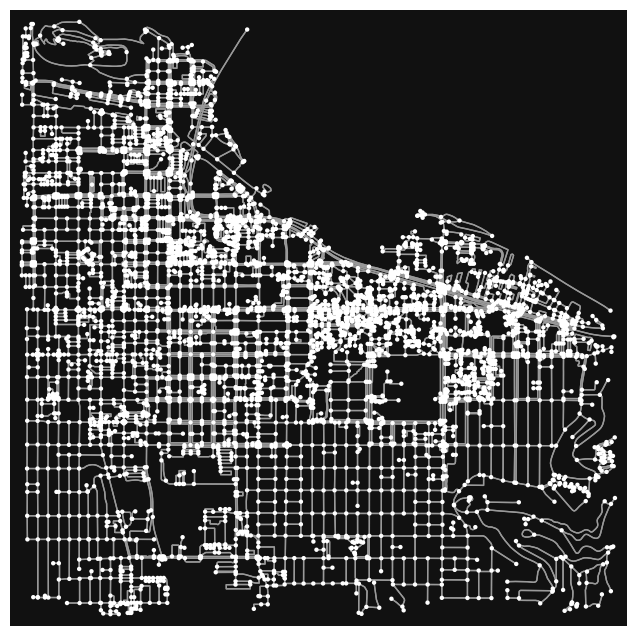

In [14]:
# Define coordinates of Condon Hall
warnings.filterwarnings("ignore", category=DeprecationWarning)
lat_lon = (44.0451, -123.0781)

# Import walkable street network data around Condon Hall
g = ox.graph_from_point(lat_lon, dist=1600, network_type='walk')

# Plot map
fig, ax = ox.plot_graph(g, node_size=10)

In [15]:
# Convert to graph
warnings.filterwarnings("ignore", category=DeprecationWarning)
graph_proj = ox.project_graph(g)

# Get edges and nodes separately
nodes_proj, edges_proj = ox.graph_to_gdfs(graph_proj, nodes=True, edges=True)

In [16]:
# Check projection is UTM Zone 10N
warnings.filterwarnings("ignore", category=DeprecationWarning)
print("Coordinate system:", edges_proj.crs)

# Convert the cafe dataset back to UTM Zone 10N
nearest_cafes = nearest_cafes.to_crs('EPSG:32610')

Coordinate system: +proj=utm +zone=10 +ellps=WGS84 +datum=WGS84 +units=m +no_defs +type=crs


In [17]:
# Get x and y coordinates of Condon Hall
orig_xy = (condon_hall['centroid'].y.values[0], condon_hall['centroid'].x.values[0])

# Get x and y coordinates of one of the cafes (the furthest of the ten)
target_xy = (nearest_cafes['centroid'].y.values[-1], nearest_cafes['centroid'].x.values[-1])

In [18]:
import scipy

# Find the node in the graph that is closest to the origin point (here, we want to get the node id)
warnings.filterwarnings("ignore", category=DeprecationWarning)
orig_node = ox.distance.nearest_nodes(G=graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)

# Find the node in the graph that is closest to the target point (here, we want to get the node id)
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

In [19]:
# Calculate the shortest path
route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

In [20]:
# Plot the shortest path using folium
warnings.filterwarnings("ignore", category=DeprecationWarning)
m = ox.plot_route_folium(g, route, weight=5)
m

## Question 2 (20 points):

Adapt the code above to compute the network distance between two points (either in Eugene or in a city of your choice) and show your results using an interactive map. Write a few sentences about what your map shows.

### Compute network distances between Condon Hall and cafes

In [21]:
# Get the nodes along the shortest path
warnings.filterwarnings("ignore", category=DeprecationWarning)
route_nodes = nodes_proj.loc[route]

# Create a geometry for the shortest path
route_line = LineString(list(route_nodes['geometry'].values))

# Create a GeoDataFrame
route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

# Print length of route
print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[-1], route_geom['geometry'].length / 1000))

Walking distance to The Quick Fix Coffee Company = 2.5 km


<ipython-input-21-c23ba9ad3742>:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[-1], route_geom['geometry'].length / 1000))


OK that looks very nice, but what about if we wanted distances to all ten cafes. We need to put this code into a for loop.

In [22]:
# Get x and y coordinates of all ten of the nearest cafes
warnings.filterwarnings("ignore", category=DeprecationWarning)
target_xy = (nearest_cafes['centroid'].y.values, nearest_cafes['centroid'].x.values)

In [23]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
routes = []
distances = []
for i in range(len(target_xy[0])):

    # Find the node in the graph that is closest to the target point (here, we want to get the node id)
    target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1][i], Y=target_xy[0][i], return_dist=False)

    # Calculate the shortest path
    route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')

    # Append route to list
    routes.append(route)

    # Get the nodes along the shortest path
    route_nodes = nodes_proj.loc[route]

    # Create a geometry for the shortest path
    route_line = LineString(list(route_nodes['geometry'].values))

    # Create a GeoDataFrame
    route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])

    # Print length of route
    print('Walking distance to %s = %.1f km' % (nearest_cafes['name'].iloc[i], route_geom['geometry'].length / 1000))

    # Append distances to list
    distances.append(route_geom['geometry'].length[0])

Walking distance to Espresso Roma = 0.2 km
Walking distance to Dutch Bros. Coffee = 1.1 km
Walking distance to Starbucks = 1.2 km
Walking distance to Palace = 1.4 km
Walking distance to Brail's Espresso = 1.6 km
Walking distance to Voodoo Doughnut = 1.6 km
Walking distance to Amazon Coffee = 1.7 km
Walking distance to Dutch Bros. Coffee = 1.5 km
Walking distance to Dutch Bros. Coffee = 2.0 km
Walking distance to The Quick Fix Coffee Company = 2.5 km


Let's add the network distances to the original DataFrame and display

In [24]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
nearest_cafes['network_distance'] = distances
nearest_cafes

,name,euclidean_distance,centroid,network_distance
5,Espresso Roma,135.288663,POINT (493611.907 4876951.876),162.529253
9,Dutch Bros. Coffee,830.864189,POINT (492960.549 4877198.252),1057.643394
3,Starbucks,1094.038306,POINT (494822.753 4876971.001),1214.423144
10,Palace,1115.624529,POINT (492791.711 4877489.898),1431.518373
1,Brail's Espresso,1225.005794,POINT (492582.859 4876464.165),1573.745910
8,Voodoo Doughnut,1240.797103,POINT (492600.687 4877399.263),1591.843411
15,Amazon Coffee,1296.504962,POINT (492548.799 4876358.612),1662.723309
6,Dutch Bros. Coffee,1369.368652,POINT (495101.061 4876873.629),1505.907030
31,Dutch Bros. Coffee,1519.720322,POINT (492413.072 4877644.513),1955.856699
25,The Quick Fix Coffee Company,1844.810972,POINT (492747.353 4875328.957),2499.779363


## Question 3 (10 points):


* a) Calculate the average difference between the Euclidean and network distances for you amenities


* b) Describe some situations where it would not be advisable to use Euclidean distances?

In [25]:
# Filter restaurants
warnings.filterwarnings("ignore", category=DeprecationWarning)

restaurants = gdf[gdf['amenity'] == 'restaurant'].reset_index()
restaurants = restaurants.to_crs('EPSG:32610')

# Get restaurants centroids
restaurants['centroid'] = restaurants['geometry'].apply(
  lambda x: x.centroid if type(x) == Polygon else (
  x.centroid if type(x) == MultiPolygon else x))

condon_hall_y = condon_hall['centroid'].y.values[0]
distances = np.sqrt(((condon_hall_x - restaurants['centroid'].x.values)**2)
                     + ((condon_hall_y - restaurants['centroid'].y.values)**2))

restaurants['euclidean_distance'] = distances

In [26]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
nearest_restaurants = restaurants.nsmallest(10, ['euclidean_distance'])[['name', 'euclidean_distance', 'centroid']]
nearest_restaurants = nearest_restaurants.set_geometry('centroid')
nearest_restaurants = nearest_restaurants.to_crs('EPSG:4326')

# Define center of map (i.e. Condon Hall) and initial zoom level
lat_lon = [44.0451, -123.0781]
m = folium.Map(location=lat_lon, zoom_start=15)

for i in range(0, nearest_restaurants.shape[0]):
    my_string = 'name: {}, distance: {}'.format(nearest_restaurants.iloc[i]['name'], nearest_restaurants.iloc[i]['euclidean_distance'])
    folium.Marker([nearest_restaurants.iloc[i]['centroid'].y, nearest_restaurants.iloc[i]['centroid'].x],
                 popup=my_string).add_to(m)

# Display map
m

In [27]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
nearest_restaurants = nearest_restaurants.to_crs('EPSG:32610')

orig_xy = (condon_hall['centroid'].y.values[0], condon_hall['centroid'].x.values[0])
target_xy = (nearest_restaurants['centroid'].y.values, nearest_restaurants['centroid'].x.values)

orig_node = ox.distance.nearest_nodes(G=graph_proj, X=orig_xy[1], Y=orig_xy[0], return_dist=False)
target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1], Y=target_xy[0], return_dist=False)

routes = []
distances = []
for i in range(len(target_xy[0])):

    target_node = ox.distance.nearest_nodes(graph_proj, X=target_xy[1][i], Y=target_xy[0][i], return_dist=False)
    route = nx.shortest_path(G=graph_proj, source=orig_node, target=target_node, weight='length')
    routes.append(route)

    route_nodes = nodes_proj.loc[route]
    route_line = LineString(list(route_nodes['geometry'].values))

    route_geom = gpd.GeoDataFrame([[route_line]], geometry='geometry', crs=edges_proj.crs, columns=['geometry'])
    # print('Walking distance to %s = %.1f km' % (nearest_restaurants['name'].iloc[i], route_geom['geometry'].length / 1000))

    distances.append(route_geom['geometry'].length[0])


nearest_restaurants['network_distance'] = distances
nearest_restaurants['distance_difference'] = abs(nearest_restaurants['network_distance'] - nearest_restaurants['euclidean_distance'])
display(nearest_restaurants)

average_difference = nearest_restaurants['distance_difference'].mean()
print(f"The average difference between network and Euclidean distances is: {average_difference:.2f} m")


,name,euclidean_distance,centroid,network_distance,distance_difference
29,Maple Garden,159.105156,POINT (493593.270 4876967.450),253.877818,94.772662
30,Sweet Basil Express,191.549120,POINT (493594.877 4877023.131),294.849915,103.300795
13,The Original Pancake House,526.941645,POINT (493535.014 4877377.985),647.384300,120.442655
23,The Elk Horn Brewery,603.926285,POINT (493397.946 4877392.430),779.243845,175.317561
22,Manola's Thai Cuisine,624.961730,POINT (493363.129 4877393.811),828.318682,203.356953
37,Chula's Restaurant & Cantina,636.172145,POINT (493334.375 4877385.933),855.281956,219.109811
14,The Jail,744.910204,POINT (493184.294 4877394.283),994.192521,249.282316
76,Night and Day boba,761.687830,POINT (493203.857 4877438.218),1004.369573,242.681743
38,Krob Krua,896.772064,POINT (492835.208 4876908.068),1018.872853,122.100789
34,Bill & Tim's Barbeque,901.104795,POINT (492833.314 4876958.073),963.199508,62.094713


The average difference between network and Euclidean distances is: 159.25 m


## b) Describe some situations where it would not be advisable to use Euclidean distances?

* W przypadkach, gdzie występują naturalne bariery, takie jak rzeki, jeziora, czy góry, które mogą uniemożliwić bezpośrednie przemieszczanie się między punktami (odległości euklidesowe nie biorą ich pod uwagę).

* W miastach, gdzie ulice i drogi często tworzą skomplikowaną siatkę, odległość euklidesowa może być myląca, gdyż nie odzwierciedla faktycznej drogi, którą musi przebyć pieszy czy pojazd.

* W przypadkach, gdzie dokładność jest kluczowa (np. systemach GPS dla kierowców), korzystanie z odległości euklidesowych może prowadzić do błędnych oszacowań czasu przejazdu i trasy.
